Pràctica: Projecto 3. Generación de números escritos a mano mediante una GAN

Autores: Bo Miquel Nordfeldt, Joan Muntaner, Helena Antich

Fecha: Mayo 2021

# Redes Generativas Antagónicas o Generative Adversarial Network (GANs)

## Librerías y descarga de datos

In [2]:
#Importamos librerías que necesitamos

%matplotlib inline # Para poder visualizar los plots e imágenes en el mismo notebook.

import numpy as np
import torch # Tratamiento tensorial con IA. 
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

In [3]:
# Número de procesos para la descarga de los datos
num_workers = 0
# Tamaño de los conjuntos de datos de "batch"
batch_size = 64

# Conversión de los datos a tensor de torch torch.FloatTensor
transform = transforms.ToTensor()

# Descarga del conjunto de datos de entrenamiento (datasets)
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Utilización de la función del "descargador de datos" DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


## Visualización de los datos

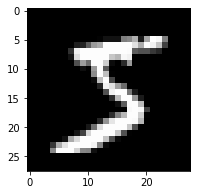

In [5]:
# Obtención de un batch de datos
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Obtención de una de las imágenes del batch
img = np.squeeze(images[0])

# Plot de la imágen seleccionada
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Definición y arquitectura del modelo

### La red Discriminadora

In [14]:
# Definimos la clase que generará la red neuronal artifical encargada de discriminar si los datos pertenecen o no al conjunto de datos de entrenamiento.

class Discriminator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal). 
    
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        
        super(Discriminator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene muchas neuronas en las
        # primeras capas y que va disminuyendo, de tamaño, paulatinamente. 
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim * 8)  
        self.capa_oculta2 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.capa_oculta3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.capa_oculta4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.capa_output = nn.Linear(hidden_dim, output_size)
        
        self.p = p 

    # Definimos la función feedforward de la red
    def forward(self, x):
        
        # Aplanamos la imagen (que esta en formato de tensor) mediante la función view de pytorch equivale a la función "flatten" de tensorflow.
        x = x.view(-1,28*28)
        # x = x.flatten(28*28)        
        
        # Pasamos la imagen aplanada por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido de pasar la imagen por la función de propagación lineal le aplicamos 
        # la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Pasamos la imagen por la capa de salida sin aplicarle, aún, la función de activación (tal y como
        # indica el enunciado).
        x = self.capa_output(x)

        return x


### Red neuronal Generadora

In [15]:
# Definimos la clase que generará la red neuronal artifical que generará datos falsos.

class Generator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal).
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        super(Generator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene pocas neuronas en las
        # primeras capas y que va aumentando, de tamaño, paulativamente.
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim)
        self.capa_oculta2 = nn.Linear(hidden_dim , hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2 , hidden_dim * 4)
        self.capa_oculta4 = nn.Linear(hidden_dim * 4 , hidden_dim * 8)
        self.capa_salida = nn.Linear(hidden_dim * 8, output_size)
        
        self.p = p
    
    # Definimos la función feedforward de la red.
    def forward(self, x):

        # Pasamos los datos (imágenes) por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido por pasar los datos por la función de propagación lineal de cada red le
        # aplicamos la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Al resultado de aplicar la capa de salida (función de propagación lineal) a los datos le aplicamos 
        # la función de la tangente hiperbólica como función de activación.
        x = torch.tanh(self.capa_salida(x))
                
        return x
    

### Hiper-parámetros del modelo

In [16]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.25

### Compilamos el modelo


In [17]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=256, bias=True)
  (capa_oculta2): Linear(in_features=256, out_features=128, bias=True)
  (capa_oculta3): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_oculta4): Linear(in_features=128, out_features=256, bias=True)
  (capa_salida): Linear(in_features=256, out_features=784, bias=True)
)


---
## Función de pérdida del discriminador y del generador

In [18]:
# Cálculo de las pérdidas

# Función de pérdida del discriminador
def real_loss(D_out, smooth):
    
    batch_size = D_out.size(0)
    
    if smooth is True: #Si la imagen se suaviza
        
        etiquetas = torch.ones(batch_size) * 0.9
        
    else:
        
        etiquetas = torch.ones(batch_size)
        
    funcion_coste = nn.BCEWithLogitsLoss() # Combina la entropía cruzada con resultado binario (BCELoss) con una sigmoide.
    
    loss = funcion_coste(D_out.squeeze(), etiquetas)
    return loss

# Función de pérdida del generador
def fake_loss(D_out):
    batch_size = D_out.size(0)

    etiquetas = torch.zeros(batch_size) 

    funcion_coste = nn.BCEWithLogitsLoss()
    
    loss = funcion_coste(D_out.squeeze(), etiquetas)

    return loss

## Optimizadores


In [19]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Entrenamiento de la primera prueba

Recodemos:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.25
- Épocas 50
- Learning rate de 0.002


In [20]:
# Hiperparámetros de entrenamiento
num_epochs = 50 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3870 | g_loss: 0.7132
Epoch [    1/   50] | d_loss: 0.6778 | g_loss: 3.8247
Epoch [    1/   50] | d_loss: 0.6386 | g_loss: 3.0390
Epoch [    2/   50] | d_loss: 0.4618 | g_loss: 4.6943
Epoch [    2/   50] | d_loss: 0.6932 | g_loss: 2.8091
Epoch [    2/   50] | d_loss: 1.0645 | g_loss: 2.0770
Epoch [    3/   50] | d_loss: 0.6117 | g_loss: 6.6481
Epoch [    3/   50] | d_loss: 0.7614 | g_loss: 2.3967
Epoch [    3/   50] | d_loss: 0.7828 | g_loss: 4.2647
Epoch [    4/   50] | d_loss: 0.7293 | g_loss: 2.6508
Epoch [    4/   50] | d_loss: 0.8286 | g_loss: 3.1313
Epoch [    4/   50] | d_loss: 0.7443 | g_loss: 2.4304
Epoch [    5/   50] | d_loss: 0.7238 | g_loss: 2.8602
Epoch [    5/   50] | d_loss: 0.6638 | g_loss: 2.8249
Epoch [    5/   50] | d_loss: 0.9414 | g_loss: 2.1026
Epoch [    6/   50] | d_loss: 0.8527 | g_loss: 2.1856
Epoch [    6/   50] | d_loss: 0.8275 | g_loss: 2.7860
Epoch [    6/   50] | d_loss: 0.8402 | g_loss: 1.9364
Epoch [    7/   50] | d_loss

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

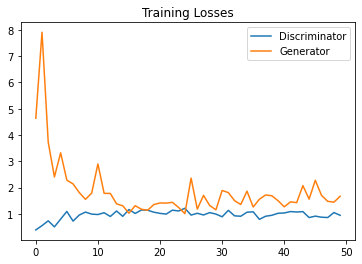

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p1 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

In [22]:
# Función para la visualización de una lista de imágenes de muestra
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [23]:
# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

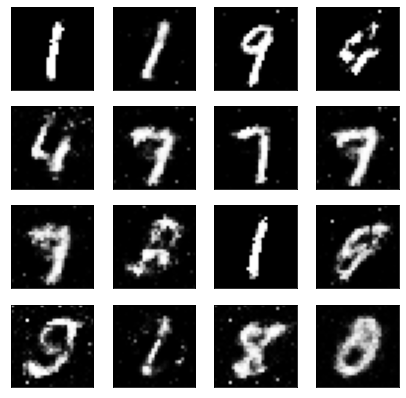

In [24]:
view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas. 

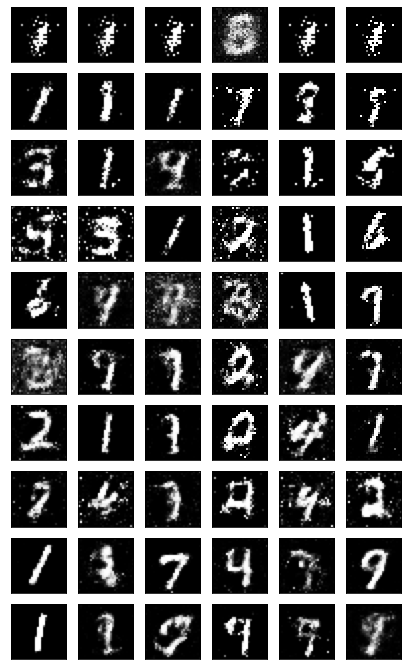

In [25]:
rows = 10 # Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Empieza siendo todo ruido. Luego aprende a hacer sólo el centro blanco y el resto negro. Puedes empezar a ver algunos números como estructuras que aparecen en el ruido como 1s y 9s.

### Nuevas imágenes generadas por el generador


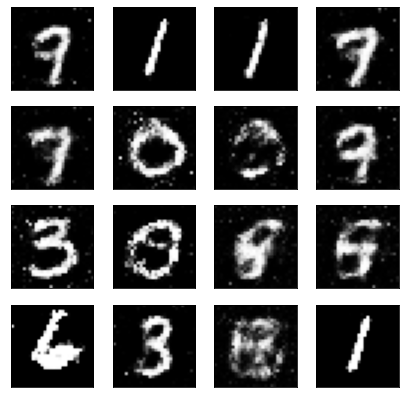

In [26]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la primera prueba

Tenemos un error bastante alto de entrenamiento tanto en la red discriminadora como en la red generadora. Además los números que produce la red generadora no son demasiado buenos, como podemo sobservar, al generador le cuesta más trabajo generar números con trazos curvos como sería en número 6, 8 y 3 por ejemplo. Por tanto, debemos seguir haciendo pruebas. 

---

## Entrenamiento de la segunda prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.35
- Épocas 60
- Lerning rate de 0.002

De esta manera, agregamos complejidad a la red generadora con la intención de mejorar los resultados obtenidos.

In [27]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.35

In [28]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=256, bias=True)
  (capa_oculta2): Linear(in_features=256, out_features=128, bias=True)
  (capa_oculta3): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_oculta4): Linear(in_features=128, out_features=256, bias=True)
  (capa_salida): Linear(in_features=256, out_features=784, bias=True)
)


In [29]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [30]:
# Hiperparámetros de entrenamiento
num_epochs = 60 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   60] | d_loss: 1.3768 | g_loss: 0.7445
Epoch [    1/   60] | d_loss: 0.4402 | g_loss: 19.3926
Epoch [    1/   60] | d_loss: 0.7960 | g_loss: 2.1231
Epoch [    2/   60] | d_loss: 1.1461 | g_loss: 1.0876
Epoch [    2/   60] | d_loss: 1.2740 | g_loss: 1.3372
Epoch [    2/   60] | d_loss: 1.1915 | g_loss: 1.1759
Epoch [    3/   60] | d_loss: 1.1544 | g_loss: 1.0013
Epoch [    3/   60] | d_loss: 0.7956 | g_loss: 2.3847
Epoch [    3/   60] | d_loss: 0.8499 | g_loss: 2.6075
Epoch [    4/   60] | d_loss: 1.0527 | g_loss: 1.5373
Epoch [    4/   60] | d_loss: 1.0464 | g_loss: 1.5194
Epoch [    4/   60] | d_loss: 1.0770 | g_loss: 1.5523
Epoch [    5/   60] | d_loss: 1.0631 | g_loss: 1.5356
Epoch [    5/   60] | d_loss: 0.9746 | g_loss: 0.9841
Epoch [    5/   60] | d_loss: 0.8496 | g_loss: 1.5823
Epoch [    6/   60] | d_loss: 1.0783 | g_loss: 1.3548
Epoch [    6/   60] | d_loss: 1.0105 | g_loss: 1.6739
Epoch [    6/   60] | d_loss: 1.0810 | g_loss: 2.3340
Epoch [    7/   60] | d_los

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

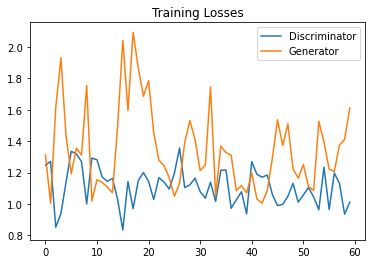

In [31]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p2 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

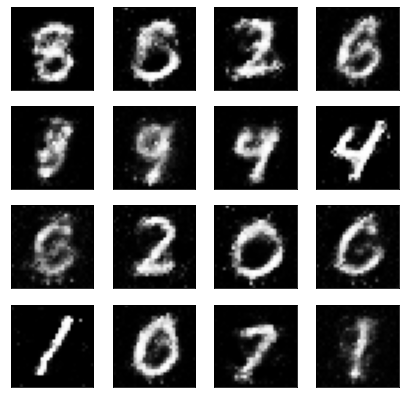

In [32]:
# Función para la visualización de una lista de imágenes de muestra
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

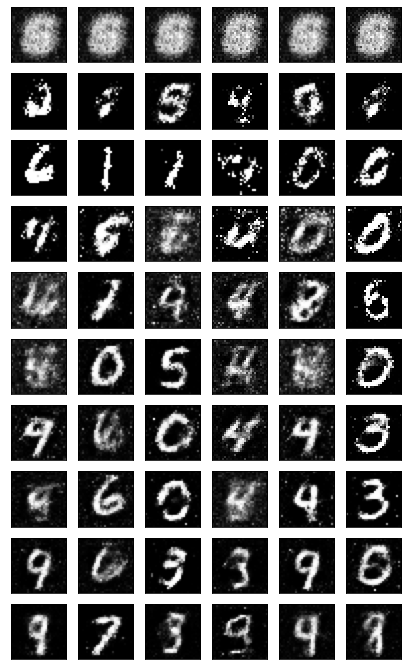

In [33]:
rows = 10 # Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

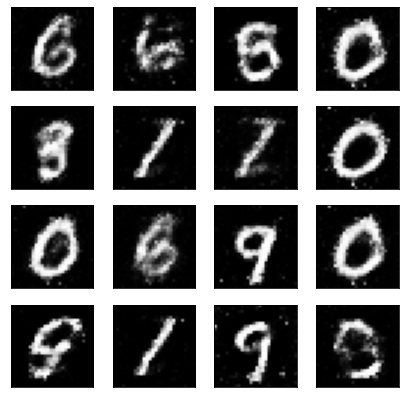

In [34]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la segunda prueba

Teniendo en cuenta el plot del error por parte del Generador y el Discriminador podemos observar que el error en el Generador es excesivo. No se llega a estabilizar el error del Generador y, aún así, el Discriminador es capaz de filtrar imágenes que reconoce que no son adecuadas. En otras palabras, los datos (imágenes de dígitos manuscritos) generados no son correctos. Sin embargo, se llega a identificar mínimamente qué número se representa.

En definitiva, este modelo es mejor que el anterior pero los resultados obtenidos no son satisfactorios. Necesitamos realizar más cambios. 

---

## Entrenamiento de la tercera prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 16 (con el número de neuronas múltiple a 16)
- Dropout del 0.40
- Épocas 80
- Learning rate 0.001

En esta ocasión, se reducen el tamaño de las capas intermedias y se aumentan las épocas para visualizar si el error se estabiliza. AL aumentar las épocas, se decide aumentar el Dropout para evitar el posible overfitting.



In [35]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 16

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 16

# Probabilidad de dropout
p = 0.40

In [36]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_oculta4): Linear(in_features=32, out_features=16, bias=True)
  (capa_output): Linear(in_features=16, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=16, bias=True)
  (capa_oculta2): Linear(in_features=16, out_features=32, bias=True)
  (capa_oculta3): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [37]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [38]:
# Hiperparámetros de entrenamiento
num_epochs = 80 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   80] | d_loss: 1.3824 | g_loss: 0.7720
Epoch [    1/   80] | d_loss: 1.1786 | g_loss: 3.9360
Epoch [    1/   80] | d_loss: 1.0810 | g_loss: 1.3499
Epoch [    2/   80] | d_loss: 0.7107 | g_loss: 2.7957
Epoch [    2/   80] | d_loss: 1.0056 | g_loss: 1.3356
Epoch [    2/   80] | d_loss: 1.1075 | g_loss: 1.1324
Epoch [    3/   80] | d_loss: 1.3422 | g_loss: 0.8742
Epoch [    3/   80] | d_loss: 1.3822 | g_loss: 0.8333
Epoch [    3/   80] | d_loss: 1.3255 | g_loss: 0.6305
Epoch [    4/   80] | d_loss: 1.1797 | g_loss: 0.9747
Epoch [    4/   80] | d_loss: 1.0704 | g_loss: 2.1825
Epoch [    4/   80] | d_loss: 1.3526 | g_loss: 0.9224
Epoch [    5/   80] | d_loss: 1.3728 | g_loss: 0.7161
Epoch [    5/   80] | d_loss: 1.1313 | g_loss: 1.4022
Epoch [    5/   80] | d_loss: 1.3359 | g_loss: 0.7441
Epoch [    6/   80] | d_loss: 1.2826 | g_loss: 0.8353
Epoch [    6/   80] | d_loss: 1.1088 | g_loss: 1.1709
Epoch [    6/   80] | d_loss: 1.2891 | g_loss: 0.8137
Epoch [    7/   80] | d_loss

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

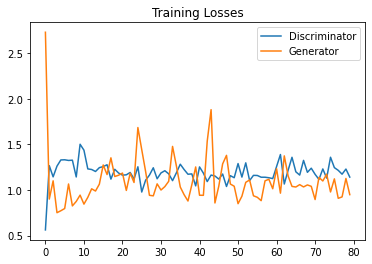

In [39]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p3 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

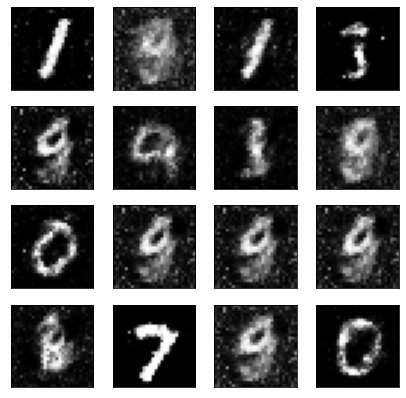

In [40]:
# Función para la visualización de una lista de imágenes de muestra
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

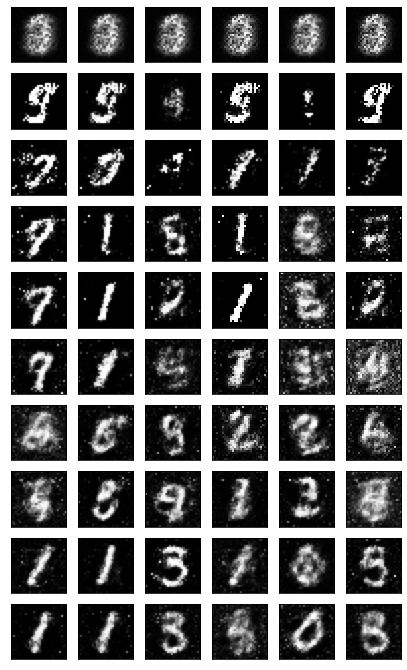

In [41]:
rows = 10 # Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

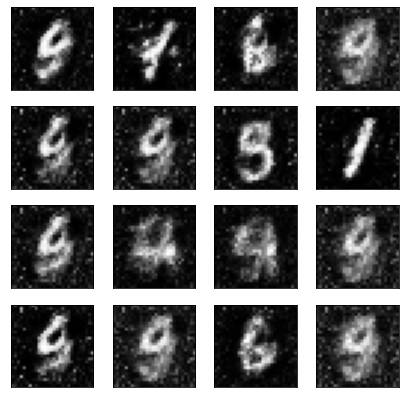

In [42]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la tercera prueba

En este modelo los resultados pueden parecer algo engañosos. Con el plot del error del Generador y Discriminador podemos observar que con un número mayor de epochs el modelo empieza a estabilizarse. Este hecho podría resultar un punto positivo. Sin embargo, si observamos las imágenes generadas es todo lo contrario. Todas las imágenes son borrosas y, por tanto, incorrectas. El Generador sigue teniendo dificultades para generar dígitos con partes curvas como en los mnúmeros 6 y 9. 

Es necesario realizar varios ajustes para observar si mejoramos los datos generados. 

---

## Entrenamiento de la cuarta prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 16 (con el número de neuronas múltiple a 16)
- Dropout del 0.40
- Épocas 100
- Learning rate 0.004

En esta prueba decidimos mantenemos la estructura inicial planteada en la pureba anterior y aumentamos las épocas y el learning rate. 

In [43]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 16

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 16

# Probabilidad de dropout
p = 0.40

In [44]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_oculta4): Linear(in_features=32, out_features=16, bias=True)
  (capa_output): Linear(in_features=16, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=16, bias=True)
  (capa_oculta2): Linear(in_features=16, out_features=32, bias=True)
  (capa_oculta3): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [45]:
# Definimos el learning rate
lr = 0.001

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [46]:
# Hiperparámetros de entrenamiento
num_epochs = 100 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.4227 | g_loss: 0.5998
Epoch [    1/  100] | d_loss: 0.7639 | g_loss: 7.5103
Epoch [    1/  100] | d_loss: 0.9808 | g_loss: 1.4712
Epoch [    2/  100] | d_loss: 1.3477 | g_loss: 1.4334
Epoch [    2/  100] | d_loss: 0.7979 | g_loss: 2.0605
Epoch [    2/  100] | d_loss: 0.8910 | g_loss: 1.5883
Epoch [    3/  100] | d_loss: 0.9959 | g_loss: 1.1399
Epoch [    3/  100] | d_loss: 1.2214 | g_loss: 1.3553
Epoch [    3/  100] | d_loss: 1.0803 | g_loss: 1.2739
Epoch [    4/  100] | d_loss: 1.1379 | g_loss: 1.6136
Epoch [    4/  100] | d_loss: 1.1717 | g_loss: 1.3877
Epoch [    4/  100] | d_loss: 1.1204 | g_loss: 1.1206
Epoch [    5/  100] | d_loss: 0.7938 | g_loss: 1.7953
Epoch [    5/  100] | d_loss: 1.1322 | g_loss: 1.0435
Epoch [    5/  100] | d_loss: 1.0964 | g_loss: 1.0122
Epoch [    6/  100] | d_loss: 1.1670 | g_loss: 1.1863
Epoch [    6/  100] | d_loss: 1.1451 | g_loss: 1.2893
Epoch [    6/  100] | d_loss: 1.0105 | g_loss: 1.3333
Epoch [    7/  100] | d_loss

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

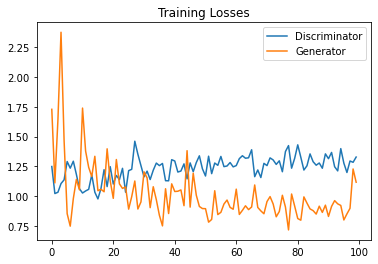

In [47]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p4 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

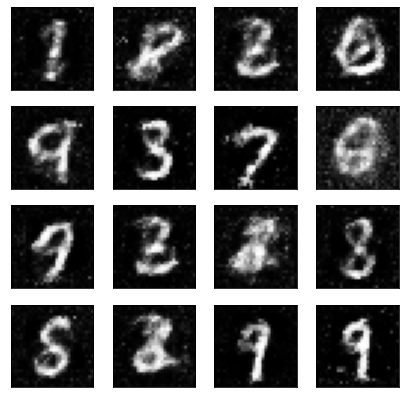

In [48]:
# Función para la visualización de una lista de imágenes de muestras
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

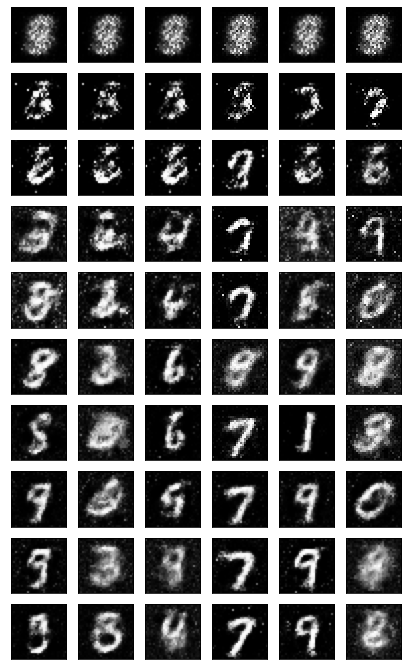

In [49]:
rows = 10# Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

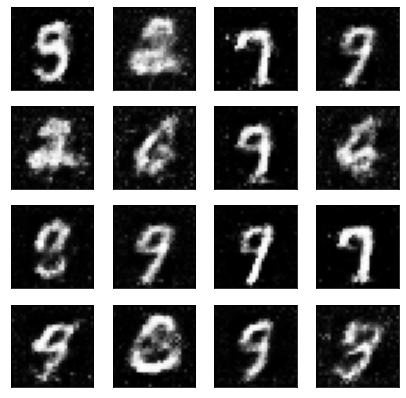

In [50]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la cuarta prueba

En esta cuarta prueba podemos observar que el Generador ha generado unos errores menores que el Discriminador. Sin embargo, si observamos los resultados obtenidos, las imágenes generadas aún no se podría considerar aceptables. Hay muchas de ellas borrosas y el modelo le sigue dando problemas generar las curvas de los dígitos. 

Se realizaran más cambios con la intención de obtener mejores resultados.

---

## Entrenamiento de la quinta prueba

Vamos a usar:
- 3 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.25
- Épocas 60
- Learning rate 0.002

Para esta prueba se ha decidido reducir el número de capas ocultas y aumentar su tamaña nuevamente a 32. Tambíen se ha reducido el Dropout y en número de épocas.

### Discriminador

In [51]:
# Definimos la clase que generará la red neuronal artifical encargada de discriminar si los datos son reales o falsos.

class Discriminator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal). 
    
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        
        super(Discriminator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene muchas neuronas en las
        # primeras capas y que va disminuyendo, de tamaño, paulativamente. 
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim * 4)  
        self.capa_oculta2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.capa_output = nn.Linear(hidden_dim, output_size)
        
        self.p = p 

    # Definimos la función feedforward de la red
    def forward(self, x):
        
        # Aplanamos la imagen (que esta en formato de tensor) mediante la función view de pytorch.
        x = x.view(-1,28*28)
        # x = x.flatten(28*28)        
        
        # Pasamos la imagen aplanada por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido de pasar la imagen por la función de propagación lineal le aplicamos 
        # la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Pasamos la imagen por la capa de salida sin aplicarle, aún, la función de activación (tal y como
        # indica el enunciado).
        x = self.capa_output(x)

        return x

### Generador

In [52]:
# Definimos la clase que generará la red neuronal artifical que generará datos falsos.

class Generator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal).
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        super(Generator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene pocas neuronas en las
        # primeras capas y que va aumentando, de tamaño, paulativamente.
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim)
        self.capa_oculta2 = nn.Linear(hidden_dim , hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2 , hidden_dim * 4)
        self.capa_salida = nn.Linear(hidden_dim * 4, output_size)
        
        self.p = p
    
    # Definimos la función feedforward de la red.
    def forward(self, x):

        # Pasamos los datos (imágenes) por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido por pasar los datos por la función de propagación lineal de cada red le
        # aplicamos la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Al resultado de aplicar la capa de salida (función de propagación lineal) a los datos le aplicamos 
        # la función de la tangente hiperbólica como función de activación.
        x = torch.tanh(self.capa_salida(x))
                
        return x
    

In [53]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.25

In [54]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [55]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [57]:
# Hiperparámetros de entrenamiento
num_epochs = 60 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   60] | d_loss: 0.8300 | g_loss: 1.5408
Epoch [    1/   60] | d_loss: 1.2283 | g_loss: 1.1828
Epoch [    1/   60] | d_loss: 1.4620 | g_loss: 0.9003
Epoch [    2/   60] | d_loss: 1.1971 | g_loss: 0.8960
Epoch [    2/   60] | d_loss: 1.0322 | g_loss: 1.2672
Epoch [    2/   60] | d_loss: 1.3562 | g_loss: 0.9052
Epoch [    3/   60] | d_loss: 1.2200 | g_loss: 1.1977
Epoch [    3/   60] | d_loss: 1.2779 | g_loss: 1.6762
Epoch [    3/   60] | d_loss: 1.1351 | g_loss: 1.3468
Epoch [    4/   60] | d_loss: 1.2623 | g_loss: 1.4062
Epoch [    4/   60] | d_loss: 1.0953 | g_loss: 1.1858
Epoch [    4/   60] | d_loss: 1.1282 | g_loss: 1.4700
Epoch [    5/   60] | d_loss: 0.8639 | g_loss: 1.7855
Epoch [    5/   60] | d_loss: 1.0478 | g_loss: 1.8475
Epoch [    5/   60] | d_loss: 0.8267 | g_loss: 4.9360
Epoch [    6/   60] | d_loss: 0.9445 | g_loss: 1.4616
Epoch [    6/   60] | d_loss: 1.0882 | g_loss: 1.1634
Epoch [    6/   60] | d_loss: 1.0346 | g_loss: 1.0159
Epoch [    7/   60] | d_loss

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

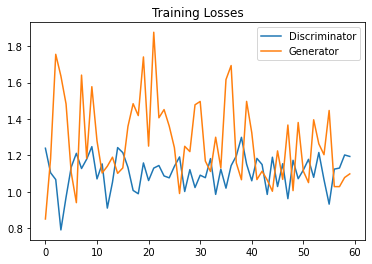

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p5 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

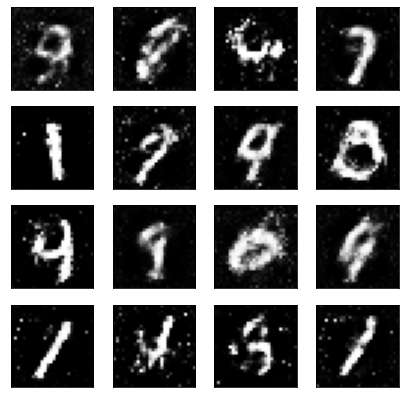

In [59]:
# Función para la visualización de una lista de imágenes de muestra
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

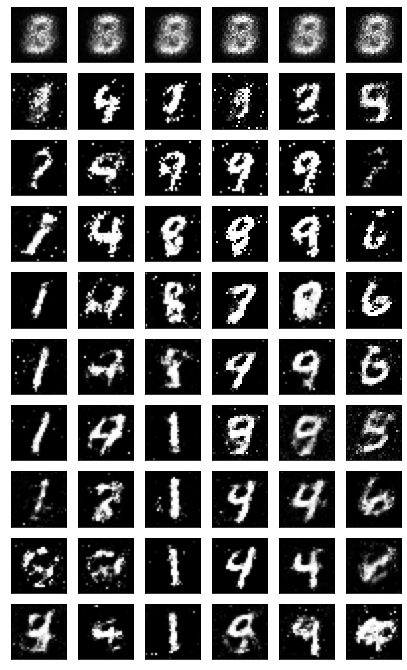

In [60]:
rows = 10 # Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

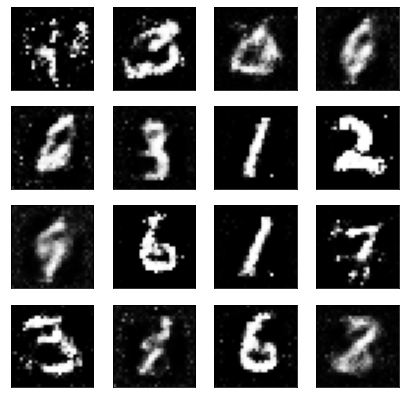

In [61]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la quinta prueba

Para este modelo se puede observar como la función de coste oscila mucho y presenta un error significativo. Además,  observando los resultados generados sigue habiendo muchas de imágenes borrosas y el modelo le sigue dando problemas generar las curvas de los dígitos. 

Se realizará un último modelo con el fín de obtener unos mejores resultados. 

---

## Entrenamiento de la sexta prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.35
- Épocas 100
- Learning rate 0.02

Para esta prueba se ha decidido volver a 4 capas ocultas y aumentamos el Dropout y en número de épocas. ADemás, se aumenta una centésima el learning rate.

### Discriminador

In [98]:
# Definimos la clase que generará la red neuronal artifical encargada de discriminar si los datos son reales o falsos.

class Discriminator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal). 
    
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        
        super(Discriminator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene muchas neuronas en las
        # primeras capas y que va disminuyendo, de tamaño, paulativamente. 
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim * 8)  
        self.capa_oculta2 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.capa_oculta3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.capa_oculta4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.capa_output = nn.Linear(hidden_dim, output_size)
        
        self.p = p 

    # Definimos la función feedforward de la red
    def forward(self, x):
        
        # Aplanamos la imagen (que esta en formato de tensor) mediante la función view de pytorch.
        x = x.view(-1,28*28)
        # x = x.flatten(28*28)        
        
        # Pasamos la imagen aplanada por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido de pasar la imagen por la función de propagación lineal le aplicamos 
        # la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Pasamos la imagen por la capa de salida sin aplicarle, aún, la función de activación (tal y como
        # indica el enunciado).
        x = self.capa_output(x)

        return x

### Generador

In [99]:
# Definimos la clase que generará la red neuronal artifical que generará datos falsos.

class Generator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal).
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        super(Generator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene pocas neuronas en las
        # primeras capas y que va aumentando, de tamaño, paulativamente.
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim)
        self.capa_oculta2 = nn.Linear(hidden_dim , hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2 , hidden_dim * 4)
        self.capa_oculta4 = nn.Linear(hidden_dim * 4 , hidden_dim * 8)
        self.capa_salida = nn.Linear(hidden_dim * 8, output_size)
        
        self.p = p
    
    # Definimos la función feedforward de la red.
    def forward(self, x):

        # Pasamos los datos (imágenes) por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido por pasar los datos por la función de propagación lineal de cada red le
        # aplicamos la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Al resultado de aplicar la capa de salida (función de propagación lineal) a los datos le aplicamos 
        # la función de la tangente hiperbólica como función de activación.
        x = torch.tanh(self.capa_salida(x))
                
        return x
    

In [100]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.5

In [101]:
# Instanciamos los modelos de discriminador y generador
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# Comprobación de que se han compilado con los hiperparámetros especificados:
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=256, bias=True)
  (capa_oculta2): Linear(in_features=256, out_features=128, bias=True)
  (capa_oculta3): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_oculta4): Linear(in_features=128, out_features=256, bias=True)
  (capa_salida): Linear(in_features=256, out_features=784, bias=True)
)


In [102]:
# Definimos el learning rate
lr = 0.001

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [103]:
# Hiperparámetros de entrenamiento
num_epochs = 100 

# Guardado de las pérdidas y la generación de imágenes falsas
samples = []
losses = []

print_every = 400

# Utilizar imágenes fijadas a lo largo del entrenamiento nos permite conocer la evolución del rendimiento de los modelos:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Entrenamiento de las redes
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Reescalado de las imágenes para el entrenamiento ## 
        real_images = real_images * 2 - 1  # reescalado de binario a bipolar, de [0,1) a [-1, 1)
        
        
        # ==========================================================================
        #           ENTRENAMIENTO DE LA R.N. DISCRIMINADORA
        # ==========================================================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Entrenamiento con imágenes reales
        # Cálculo de las pérdidas con imágenes reales utilizando etiquetas suavizadas
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Entrenamiento con imágenes falsas        
        # Generación de las imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Cálculo de las pérdidas con imágenes reales
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Juntamos las imágenes reales y falsas y se ejecuta el "backpropagation"
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # ========================================================================
        #           ENTRENAMIENTO DE LA R.N. GENERADORA
        # ========================================================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Entrenamiento con imágenes falsas y etiquetas giradas
        # Generación de imágenes falsas
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        # Cálculo de las pérdidas del discriminador con con imágenes reales con las etiquetas giradas
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print de las perdidas por época
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Después de cada época##
    # guardado de las pérdidas de ambas redes neuronales en una array de arrays
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generación y guardado de un ejemplo de imágenes falsas
    G.eval() # Activación del modo de evaluación del modelo para la generación 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Activación del modo de entrenamiento de nuevo


# Guardado de los ejemplos generados durante el entrenamiento del generador
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3913 | g_loss: 0.6632
Epoch [    1/  100] | d_loss: 1.1868 | g_loss: 1.4134
Epoch [    1/  100] | d_loss: 0.7986 | g_loss: 1.6848
Epoch [    2/  100] | d_loss: 0.9796 | g_loss: 1.7491
Epoch [    2/  100] | d_loss: 0.9533 | g_loss: 1.2523
Epoch [    2/  100] | d_loss: 1.0201 | g_loss: 1.4058
Epoch [    3/  100] | d_loss: 1.2783 | g_loss: 0.9579
Epoch [    3/  100] | d_loss: 1.1368 | g_loss: 1.2829
Epoch [    3/  100] | d_loss: 1.1314 | g_loss: 1.1414
Epoch [    4/  100] | d_loss: 1.3345 | g_loss: 1.4929
Epoch [    4/  100] | d_loss: 1.2700 | g_loss: 1.4076
Epoch [    4/  100] | d_loss: 1.2231 | g_loss: 1.1210
Epoch [    5/  100] | d_loss: 1.3147 | g_loss: 1.2737
Epoch [    5/  100] | d_loss: 1.0531 | g_loss: 1.5369
Epoch [    5/  100] | d_loss: 1.2292 | g_loss: 1.1194
Epoch [    6/  100] | d_loss: 1.2389 | g_loss: 1.2297
Epoch [    6/  100] | d_loss: 1.2685 | g_loss: 1.0231
Epoch [    6/  100] | d_loss: 1.1933 | g_loss: 1.2121
Epoch [    7/  100] | d_loss

### Pérdidas en el entrenamiento

Vamos a plotear la evolución del coste durante el entrenamiento

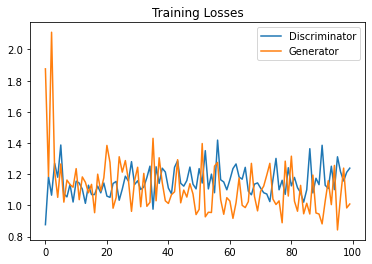

In [104]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_p6 = losses
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

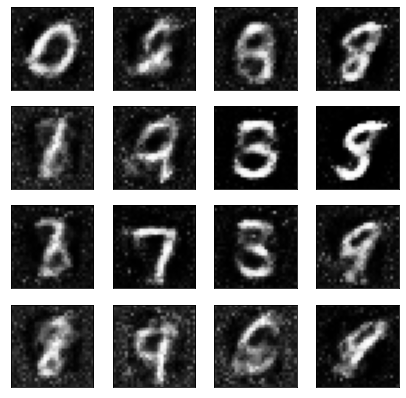

In [105]:
# Función para la visualización de una lista de imágenes de muestra
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Carga de las imágenes generadas durante el entrenamiento
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples) # -1 para seleccionar las últimas imágenes generadas, en la última época

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

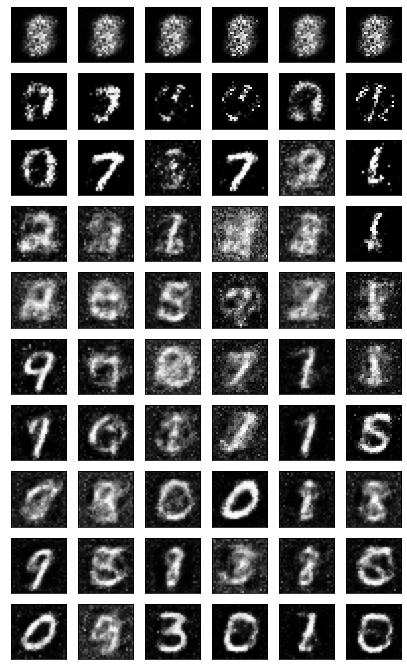

In [106]:
rows = 10 # Selección de una época cada 10 épocas
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

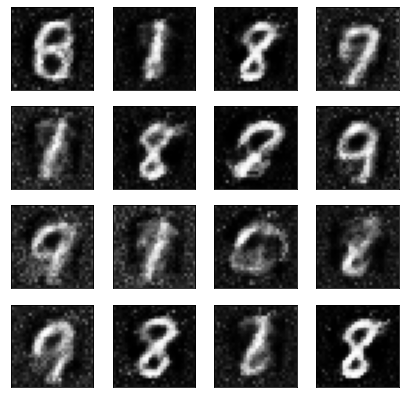

In [107]:
# Generación aleatoria de los vectores latentes
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # Modo de evaluación
# Ejemplos generados
rand_images = G(rand_z)

view_samples(0, [rand_images]) # 0 para el primer elemento de la lista

### Conclusiones de la sexta prueba

Para esta última prueba, aumentando considerablemente el número de épocas y el porcentage del Dropout al 50%. Siendo cierto el efecto del aumento del dropout, los resultados sobre la función de coste son parecidos al resto de pruebas realizadas. En cuanto a los datos generados, podemos observar que aún se obtinen imágenes borrosas. Además, en la generación de dígitos con varias curvas parece que los resultados son mejores, como por ejemplo en la generación de números como el 0, 3 y 8. Sin embargo, en la generación de dígitos más varticales, como sería el número 7, las pruebas anteriores presentaban lígeras mejoras.

## Comparación entre modelos

Después de realizar las seis pruebas expuestas, para finalizar este ejercicio se ha decidido comparar la evolución de las funciones de coste de cada modelo con el fín de decidir qué modelo es el mejor. Para ello se han ido guardando todas las pérdidas de cada modelo en una variable con el nombre "losses_pX", donde X es el número de cada modelo. De esta manera, podemos visualizar dichas pérdidas en una sola gráfica.

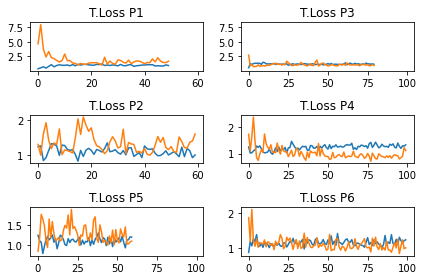

In [109]:
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(losses_p1.T[0], label = "")
axs[0, 0].plot(losses_p1.T[1], label = "")
axs[0, 0].set_title("T.Loss P1")
axs[1, 0].plot(losses_p2.T[0], label = "")
axs[1, 0].plot(losses_p2.T[1], label = "")
axs[1, 0].set_title("T.Loss P2")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(losses_p3.T[0], label = "")
axs[0, 1].plot(losses_p3.T[1], label = "")
axs[0, 1].set_title("T.Loss P3")
axs[0, 1].sharey(axs[0, 0])
axs[1, 1].plot(losses_p4.T[0], label = "")
axs[1, 1].plot(losses_p4.T[1], label = "")
axs[1, 1].set_title("T.Loss P4")
axs[1, 1].sharex(axs[0, 1])
axs[2, 0].plot(losses_p5.T[0], label = "")
axs[2, 0].plot(losses_p5.T[1], label = "")
axs[2, 0].set_title("T.Loss P5")
axs[2, 0].sharex(axs[0, 1])
axs[2, 1].plot(losses_p6.T[0], label = "")
axs[2, 1].plot(losses_p6.T[1], label = "")
axs[2, 1].set_title("T.Loss P6")
axs[2, 1].sharex(axs[0, 1])
fig.tight_layout()

Como se puede observar, la media de los errores está entre 1 y 2.5 para todas las gráficas, aunque el error inicial sea mayor para algunas mayor. Teniendo en cuenta los errores, las pruebas 5 y 6 son las que tienen los errores de valor más pequeño. Si además observamos el número de épocas, la quinta prueba es más rápida a la hora de alcanzar valores más pequeños de coste. 

## Conclusión final

Tras el plot anterior, podemos observar que la quinta prueba es la que resulta en un compromiso entre el coste computacional y el coste o pérdida. Recordemos que la configuración de las redes de la quinta prueba es la siguiente:

- 3 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.25
- Épocas 60
- Learning rate 0.002

Por todo esto, seleccionamos la quinta prueba, con la configuración arriba mencionada, como la solución más adecuada al problema de la generación de números escritos a mano mediante una red generativa antagónica o GAN.